In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from DataPrep.ImportData import importer
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


In [3]:
m = modelling()
df = m.df.drop(columns=["Charging Time (mins)", "Total Duration (mins)", "Port Number"])

In [4]:
cols_to_standardize = ['# Professional & Other Places', '# Food', '# Shop & Service',
       '# Travel & Transport', '# Outdoors & Recreation',
       '# Arts & Entertainment', '# Nightlife Spot', '# Residence',
       '# College & University', '# Event']

sc = StandardScaler()
stand_poi = sc.fit_transform(df[cols_to_standardize])
stand_poi = pd.DataFrame(stand_poi, index=df.index, columns=cols_to_standardize)
for i in cols_to_standardize:
    df[i] = stand_poi[i]

<IPython.core.display.Javascript object>

In [5]:
df = df.fillna(0)

In [6]:
df.head()

,Start Date,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
0,2011-08-03,0.0,1.679882,-122.16,37.445,0,8,2.098609,1.260311,2.325573,...,0,0,0,1,0,0,0,0,0,0
1,2011-08-04,0.0,1.899242,-122.16,37.445,0,5,1.679882,2.098609,1.260311,...,0,0,0,1,0,0,0,0,0,0
2,2011-08-05,0.0,1.574471,-122.16,37.445,0,10,1.899242,1.679882,2.098609,...,0,0,0,1,0,0,0,0,0,0
3,2011-08-06,0.0,1.982032,-122.16,37.445,0,14,1.574471,1.899242,1.679882,...,0,0,0,1,0,0,0,0,0,1
4,2011-08-07,0.0,2.232860,-122.16,37.445,0,3,1.982032,1.574471,1.899242,...,0,0,0,1,0,0,0,0,0,1


In [7]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")

In [8]:
labels = df.Label.unique()

In [9]:
df_reindex = pd.DataFrame()
idx = pd.period_range(min(df.index), max(df.index))
for i in labels:
    filling = df[df.Label == i].reindex(idx, fill_value = 0)
    filling.Label = i
    df_reindex = df_reindex.append(filling)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
df = df_reindex.sort_index()

In [11]:
df.head()

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2011-08-03,0.0,1.679882,-122.16,37.445,0,8,2.098609,1.260311,2.325573,1.726841,...,0,0,0,1,0,0,0,0,0,0
2011-08-03,3.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,4.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,1.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,7.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [947]:
def create_dataset(X, y, time_slot=1):
    Xs, ys = [], []
    for i in range(int((len(X) - time_slot)/8)):
        v = X.iloc[i*8:(i*8 + time_slot)].values
        Xs.append(v)
        ys.append(y[i*8 + time_slot - 1 : i*8 + time_slot + 7])
    return np.array(Xs), np.array(ys)

In [734]:
X_train["Energy (kWh)"].iloc[16+182]

1.883753375

In [919]:
y_train[16+182]

array([1.89159379, 0.        , 0.        , 1.56665672, 1.32957054,
       0.        , 0.        , 1.4445925 ])

In [920]:
X_train

array([[[   0.        ,    1.67988194, -122.16      , ...,
            0.        ,    0.        ,    0.        ],
        [   3.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   4.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        ...,
        [   4.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    1.85034893, -122.16      , ...,
            0.        ,    0.        ,    0.        ],
        [   7.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[   1.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    1.8992418 , -122.16      , ...,
            0.        ,    0.        ,    0.        ],
        [   3.        ,    0.        ,    0.        , ...,
            0.

In [179]:
df.head()

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2011-08-03,0.0,1.679882,-122.16,37.445,0,8,2.098609,1.260311,2.325573,1.726841,...,0,0,0,1,0,0,0,0,0,0
2011-08-03,3.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,4.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,1.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2011-08-03,7.0,0.000000,0.00,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [180]:
def ttsplit(df,target="Energy (kWh)",shuffle=False):
    X = df
    y = df[target]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=42,shuffle=shuffle)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.10, random_state=42,shuffle=shuffle)

    return X_train,X_test, X_val,y_train,y_test, y_val

In [850]:
X_train, X_test, X_val, y_train, y_test, y_val = ttsplit(df, shuffle = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using 182, cause 182.5 is half a year

In [857]:
X_train,y_train = create_dataset(X_train, y_train, time_slot = 182*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [858]:
X_test,y_test = create_dataset(X_test, y_test, time_slot = 182*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [859]:
X_val,y_val = create_dataset(X_val, y_val, time_slot = 182*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [781]:
X_train.shape

(2030, 1456, 81)

In [782]:
X_train[1:2,:,1:2].shape

(1, 1456, 1)

In [783]:
df[1456:1456+8]

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2012-02-01,3.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,5.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,7.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,4.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,6.0,0.000000,0.000,0.000,0,0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,0.0,1.343549,-122.160,37.445,0,3,1.850349,1.157048,1.186390,1.960185,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,1.0,1.335339,-122.163,37.444,0,3,1.305929,1.503150,1.490880,1.424672,...,0,0,0,0,0,0,0,0,0,0
2012-02-01,2.0,1.618067,-122.162,37.447,0,10,2.117777,1.648771,1.364038,1.070227,...,0,0,0,0,0,0,0,0,0,0


In [956]:
X_train_new, y_train_new = create_dataset(df[0:2920],df["Energy (kWh)"][0:2920], time_slot = 31*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [960]:
X_train_new.shape

(334, 248, 81)

In [961]:
X_val_new, y_val_new = create_dataset(df[2920:2920+1456],df["Energy (kWh)"][2920:2920+1456], time_slot = 31*8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [972]:
inputs = Input(shape=(None,81))
x = LSTM(80, return_sequences = True, activation = "tanh")(inputs)
x = Dropout(0.1)(x)
x = LSTM(80, return_sequences = False, activation = "tanh")(inputs)
x = Dense(8, activation="relu")(x)
outputs = Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
#opt = keras.optimizers.Adam(learning_rate=1*10**(-4))
model.compile(optimizer="Adam", loss='mse', metrics=["mae"])

history = model.fit(X_train_new, y_train_new, epochs=200, batch_size=1, validation_data = (X_val_new, y_val_new))

Epoch 1/200
334/334 [==============================] - 15s 41ms/step - loss: 0.9002 - mae: 0.7251 - val_loss: 0.7165 - val_mae: 0.7847
Epoch 2/200
334/334 [==============================] - 12s 35ms/step - loss: 0.6913 - mae: 0.7432 - val_loss: 0.7207 - val_mae: 0.7528
Epoch 3/200
334/334 [==============================] - 12s 35ms/step - loss: 0.6785 - mae: 0.7277 - val_loss: 0.7207 - val_mae: 0.7523
Epoch 4/200
334/334 [==============================] - 11s 33ms/step - loss: 0.7102 - mae: 0.7479 - val_loss: 0.7166 - val_mae: 0.7635
Epoch 5/200
334/334 [==============================] - 11s 33ms/step - loss: 0.7027 - mae: 0.7433 - val_loss: 0.7180 - val_mae: 0.7586
Epoch 6/200
334/334 [==============================] - 11s 33ms/step - loss: 0.6920 - mae: 0.7385 - val_loss: 0.7157 - val_mae: 0.7729
Epoch 7/200
334/334 [==============================] - 11s 34ms/step - loss: 0.6937 - mae: 0.7399 - val_loss: 0.7204 - val_mae: 0.7553
Epoch 8/200
334/334 [==============================] - 

KeyboardInterrupt: 

In [964]:
model.predict(np.array(X_val[0]).reshape(1,1456,81))

<IPython.core.display.Javascript object>

array([[0.5611645]], dtype=float32)

In [561]:
X_val[0][-1][1]

2.692439024390244

In [580]:
model.predict(np.array(df[-1458:-2]).reshape(1,1456,81))

<IPython.core.display.Javascript object>

array([[2.7247455]], dtype=float32)

In [584]:
X_val.shape

(63, 1456, 81)

In [611]:
float(model.predict(np.array(df[-1458:-2]).reshape(1,1456,81)))

<IPython.core.display.Javascript object>

2.724745512008667

In [612]:
df.iloc[-1]["Energy (kWh)"]

3.383807692307693

In [965]:
def predic():
    preds = []
    for i in range(100):
        pred = float(model.predict(np.array(df[-1358+i:-102+i]).reshape(1,1256,81)))
        preds.append(pred)
    
    return preds

In [967]:
preds = predic()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [968]:
r2_score(np.array(df[-101:-1]["Energy (kWh)"]),np.array(preds))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-4.731077014302545

In [969]:
preds = []
for i in range(X_val.shape[0]):
    pred = model.predict(np.array(X_val[i]).reshape(1,1456,81))
    preds.append(float(pred))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [970]:
preds

[0.5611644983291626,
 0.5701436996459961,
 0.5911750197410583,
 0.5864356756210327,
 0.5948604941368103,
 0.6334630846977234,
 0.5695988535881042,
 0.5648144483566284,
 0.5442633628845215,
 0.4975155293941498,
 0.5873321294784546,
 0.6605113744735718,
 0.5594258308410645,
 0.6802462935447693,
 0.5902557969093323,
 0.6363338828086853,
 0.645184338092804,
 0.6324993371963501,
 0.6544402837753296,
 0.5992485284805298,
 0.5528717041015625,
 0.5810484886169434,
 0.6608498096466064,
 0.6520194411277771,
 0.6644423604011536,
 0.6175932288169861,
 0.6048698425292969,
 0.6740634441375732,
 0.5644179582595825,
 0.636368453502655,
 0.62565678358078,
 0.7037426233291626,
 0.6325733065605164,
 0.6466323137283325,
 0.692121684551239,
 0.5724148750305176,
 0.5354454517364502,
 0.6129343509674072,
 0.6178449988365173,
 0.6450437307357788,
 0.5890757441520691,
 0.5898423194885254,
 0.6192377209663391,
 0.5511139035224915,
 0.6237726211547852,
 0.6506972312927246,
 0.6842180490493774,
 0.696781158447265

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

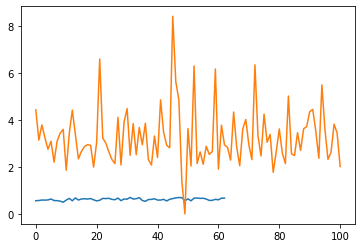

In [971]:
plt.plot(preds)
plt.plot(np.array(df[-102:-1]["Energy (kWh)"]))

## Bayesian Hyperparamter Tuning

In [973]:
import kerastuner as kt

In [974]:
def model_builder(hp):
    model = Sequential()
    mod
    for i in range(hp.Int('LSTM_layers',1,3)):
        model.add(LSTM(hp.Int(f'lstm{i}_units', min_value=10, max_value=80, step=5), return_sequences = True, activation = "tanh"))
        model.add(Dropout(hp.Float(f'lstm{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    for i in range(hp.Int('Dense_layers',1,3)):
        model.add(Dense(hp.Int(f'dense{i}_units', min_value=5, max_value=65, step=5), activation = "relu"))
        model.add(Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    model.add(Dense(1))
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss = 'mse', metrics=['mae'])
    
    return model

In [975]:
def model_builder(hp):

    inputs = Input(shape=(None,81))
    
    x = LSTM(hp.Int('lstm0_units', min_value=20, max_value=60, step=2), return_sequences = True, activation = "tanh")(inputs)
    x = Dropout(hp.Float(f'lstm0_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    lstm_layers = hp.Int('LSTM_layers',1,2)
    for i in range(lstm_layers):
        if i == max(range(lstm_layers)):
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = False, activation = "tanh")(x)
        else:
            x = LSTM(hp.Int(f'lstm{i + 1}_units', min_value=4, max_value=38, step=2), return_sequences = True, activation = "tanh")(x)
        x = Dropout(hp.Float(f'lstm{i + 1}_dropout', min_value=0, max_value=0.9, step=0.1))(x)
    
    for i in range(hp.Int('Dense_layers',0,3)):
        x = Dense(hp.Int(f'dense_units_{i}', min_value=1, max_value=15, step=1), activation="relu")(x)
        x = Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1))(x)


    outputs = Dense(1)(x)

    m = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
    
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    m.compile(optimizer=opt, loss='mse', metrics=["mae"])

    return m

In [976]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_mae',
                     max_trials = 100,
                     directory='Modelling/HyperParameterTuning',
                     project_name='LSTM_small')

In [977]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

<IPython.core.display.Javascript object>

In [934]:
y_val.shape

(63, 8)

In [978]:
tuner.search(X_train_new, y_train_new, epochs=100 , batch_size=1, validation_data=(X_val_new,y_val_new), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 32 Complete [02h 52m 49s]
val_mae: 0.6668657064437866

Best val_mae So Far: 0.6231744289398193
Total elapsed time: 21h 16m 20s

Search: Running Trial #33

Hyperparameter    |Value             |Best Value So Far 
lstm0_units       |50                |58                
lstm0_dropout     |0.9               |0.9               
LSTM_layers       |1                 |1                 
lstm1_units       |38                |14                
lstm1_dropout     |0.9               |0.9               
Dense_layers      |3                 |2                 
learning_rate     |0.0001            |0.0001            
lstm2_units       |4                 |4                 
lstm2_dropout     |0                 |0.3               
dense_units_0     |1                 |1                 
dense0_dropout    |0                 |0                 
dense_units_1     |1                 |1                 
dense1_dropout    |0.9               |0                 
dense_units_2     |1                 |1  

KeyboardInterrupt: 